In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Check GPU type

True
Tesla T4


In [2]:
%%writefile cuda_kernels.cu
#include <cuda_runtime.h>
#include <math_constants.h>

__global__ void double_elements_kernel(float* input, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        input[idx] = input[idx] * 2.0f;
    }
}

__global__ void double_elements_backward_kernel(float* grad_output, float* grad_input, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        grad_input[idx] = grad_output[idx] * 2.0f;
    }
}

extern "C" {
    void launch_double_elements(float* input, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        double_elements_kernel<<<gridSize, blockSize>>>(input, n);
        cudaDeviceSynchronize();
    }

    void launch_double_elements_backward(float* grad_output, float* grad_input, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        double_elements_backward_kernel<<<gridSize, blockSize>>>(grad_output, grad_input, n);
        cudaDeviceSynchronize();
    }
}

__global__ void conv_transpose_general_kernel(const float* input, const float* weight, float* output,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in,
    int H_out, int W_out,
    int kH, int kW,
    int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch * out_channels * H_out * W_out;
    if (idx < total) {
        // Decode the output index into (n, oc, y, x)
        int temp = idx;
        int x = temp % W_out;
        temp /= W_out;
        int y = temp % H_out;
        temp /= H_out;
        int oc = temp % out_channels;
        int n = temp / out_channels;

        float sum = 0.0f;
        for (int ic = 0; ic < in_channels; ic++) {
            for (int ky = 0; ky < kH; ky++) {
                for (int kx = 0; kx < kW; kx++) {
                    int i_y = y + padding - ky;
                    int i_x = x + padding - kx;
                    if (i_y % stride == 0 && i_x % stride == 0) {
                        i_y /= stride;
                        i_x /= stride;
                        if (i_y >= 0 && i_y < H_in && i_x >= 0 && i_x < W_in) {
                            int input_idx = ((n * in_channels + ic) * H_in + i_y) * W_in + i_x;
                            int flipped_ky = kH - 1 - ky;
                            int flipped_kx = kW - 1 - kx;
                            int weight_idx = ((ic * out_channels + oc) * kH + flipped_ky) * kW + flipped_kx;
                            sum += input[input_idx] * weight[weight_idx];
                        }
                    }
                }
            }
        }
        output[idx] = sum;
    }
}

extern "C" {
    void launch_conv_transpose_general(const float* input, const float* weight, float* output,
        int batch, int in_channels, int out_channels,
        int H_in, int W_in,
        int H_out, int W_out,
        int kH, int kW,
        int stride, int padding) {

        int total = batch * out_channels * H_out * W_out;
        int blockSize = 256;
        int gridSize = (total + blockSize - 1) / blockSize;
        conv_transpose_general_kernel<<<gridSize, blockSize>>>(input, weight, output,
            batch, in_channels, out_channels,
            H_in, W_in,
            H_out, W_out,
            kH, kW,
            stride, padding);
        cudaDeviceSynchronize();
    }
}

__global__ void batchnorm_compute_mean_var(const float* input, float* mean, float* var, int N, int C, int H, int W) {
    int c = blockIdx.x; // one block per channel
    int channel_size = N * H * W;
    __shared__ float shared_sum[256];
    float sum = 0.0f;
    for (int i = threadIdx.x; i < channel_size; i += blockDim.x) {
        int n = i / (H * W);
        int rem = i % (H * W);
        int h = rem / W;
        int w = rem % W;
        int idx = ((n * C + c) * H + h) * W + w;
        sum += input[idx];
    }
    shared_sum[threadIdx.x] = sum;
    __syncthreads();
    // Reduce within block.
    for (int stride = blockDim.x / 2; stride > 0; stride /= 2) {
        if (threadIdx.x < stride)
            shared_sum[threadIdx.x] += shared_sum[threadIdx.x + stride];
        __syncthreads();
    }
    if (threadIdx.x == 0)
        mean[c] = shared_sum[0] / channel_size;
    __syncthreads();

    __shared__ float shared_sum2[256];
    float sum_sq = 0.0f;
    float m = mean[c];
    for (int i = threadIdx.x; i < channel_size; i += blockDim.x) {
        int n = i / (H * W);
        int rem = i % (H * W);
        int h = rem / W;
        int w = rem % W;
        int idx = ((n * C + c) * H + h) * W + w;
        float diff = input[idx] - m;
        sum_sq += diff * diff;
    }
    shared_sum2[threadIdx.x] = sum_sq;
    __syncthreads();
    for (int stride = blockDim.x / 2; stride > 0; stride /= 2) {
        if (threadIdx.x < stride)
            shared_sum2[threadIdx.x] += shared_sum2[threadIdx.x + stride];
        __syncthreads();
    }
    if (threadIdx.x == 0)
        var[c] = shared_sum2[0] / channel_size;
}

__global__ void batchnorm_apply(const float* input, float* output, const float* mean, const float* var,
                                const float* gamma, const float* beta, int N, int C, int H, int W, float eps) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = N * C * H * W;
    if (idx < total) {
        int n = idx / (C * H * W);
        int rem = idx % (C * H * W);
        int c = rem / (H * W);
        int r = rem % (H * W);
        int h = r / W;
        int w = r % W;
        int index = ((n * C + c) * H + h) * W + w;
        float m = mean[c];
        float v = var[c];
        float norm = (input[index] - m) / sqrtf(v + eps);
        output[index] = gamma[c] * norm + beta[c];
    }
}

extern "C" {
    void launch_batchnorm(const float* input, float* output, const float* gamma, const float* beta,
                          int N, int C, int H, int W, float eps) {
        int channel_size = N * H * W;
        float *mean, *var;
        size_t size = C * sizeof(float);
        cudaMalloc(&mean, size);
        cudaMalloc(&var, size);

        int blockSize = 256;
        int gridSize = C;  // one block per channel.
        batchnorm_compute_mean_var<<<gridSize, blockSize>>>(input, mean, var, N, C, H, W);
        cudaDeviceSynchronize();

        int total = N * C * H * W;
        blockSize = 256;
        gridSize = (total + blockSize - 1) / blockSize;
        batchnorm_apply<<<gridSize, blockSize>>>(input, output, mean, var, gamma, beta, N, C, H, W, eps);
        cudaDeviceSynchronize();

        cudaFree(mean);
        cudaFree(var);
    }
}

__global__ void conv2d_kernel(const float* input, const float* weight, float* output,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in,
    int H_out, int W_out,
    int kH, int kW,
    int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch * out_channels * H_out * W_out;
    if (idx < total) {
        // Decode index into (n, oc, y, x)
        int temp = idx;
        int x = temp % W_out; temp /= W_out;
        int y = temp % H_out; temp /= H_out;
        int oc = temp % out_channels; temp /= out_channels;
        int n = temp;

        float sum = 0.0f;
        // For each input channel and kernel element:
        for (int ic = 0; ic < in_channels; ic++) {
            for (int ky = 0; ky < kH; ky++) {
                for (int kx = 0; kx < kW; kx++) {
                    int in_y = y * stride - padding + ky;
                    int in_x = x * stride - padding + kx;
                    if (in_y >= 0 && in_y < H_in && in_x >= 0 && in_x < W_in) {
                        int input_idx = ((n * in_channels + ic) * H_in + in_y) * W_in + in_x;
                        // Weight shape: (out_channels, in_channels, kH, kW)
                        int weight_idx = ((oc * in_channels + ic) * kH + ky) * kW + kx;
                        sum += input[input_idx] * weight[weight_idx];
                    }
                }
            }
        }
        output[idx] = sum;
    }
}

extern "C" {
    void launch_conv2d(const float* input, const float* weight, float* output,
         int batch, int in_channels, int out_channels,
         int H_in, int W_in,
         int H_out, int W_out,
         int kH, int kW,
         int stride, int padding) {
         int total = batch * out_channels * H_out * W_out;
         int blockSize = 256;
         int gridSize = (total + blockSize - 1) / blockSize;
         conv2d_kernel<<<gridSize, blockSize>>>(input, weight, output,
             batch, in_channels, out_channels,
             H_in, W_in,
             H_out, W_out,
             kH, kW,
             stride, padding);
         cudaDeviceSynchronize();
    }
}

__global__ void relu_kernel(const float* input, float* output, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float x = input[idx];
        output[idx] = (x > 0.0f) ? x : 0.0f;
    }
}

__global__ void relu_backward_kernel(const float* input, const float* grad_output, float* grad_input, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        grad_input[idx] = (input[idx] > 0.0f) ? grad_output[idx] : 0.0f;
    }
}

extern "C" {
    void launch_relu(const float* input, float* output, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        relu_kernel<<<gridSize, blockSize>>>(input, output, n);
        cudaDeviceSynchronize();
    }

    void launch_relu_backward(const float* input, const float* grad_output, float* grad_input, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        relu_backward_kernel<<<gridSize, blockSize>>>(input, grad_output, grad_input, n);
        cudaDeviceSynchronize();
    }
}

__global__ void conv_transpose2d_backward_input_kernel(
    const float* d_output, const float* weight, float* d_input,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in, int H_out, int W_out,
    int kH, int kW, int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch * in_channels * H_in * W_in;
    if (idx < total) {
        int temp = idx;
        int x = temp % W_in;
        temp /= W_in;
        int y = temp % H_in;
        temp /= H_in;
        int ic = temp % in_channels;
        int n = temp / in_channels;

        float sum = 0.0f;
        for (int oc = 0; oc < out_channels; oc++) {
            for (int ky = 0; ky < kH; ky++) {
                for (int kx = 0; kx < kW; kx++) {
                    int o_y = y * stride - padding + ky;
                    int o_x = x * stride - padding + kx;
                    if (o_y >= 0 && o_y < H_out && o_x >= 0 && o_x < W_out) {
                        int d_output_idx = ((n * out_channels + oc) * H_out + o_y) * W_out + o_x;
                        int weight_idx = ((ic * out_channels + oc) * kH + ky) * kW + kx;
                        sum += d_output[d_output_idx] * weight[weight_idx];
                    }
                }
            }
        }
        d_input[idx] = sum;
    }
}

__global__ void conv_transpose2d_backward_weight_kernel(
    const float* input, const float* d_output, float* d_weight,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in, int H_out, int W_out,
    int kH, int kW, int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = in_channels * out_channels * kH * kW;
    if (idx < total) {
        int temp = idx;
        int kx = temp % kW;
        temp /= kW;
        int ky = temp % kH;
        temp /= kH;
        int oc = temp % out_channels;
        int ic = temp / out_channels;

        float sum = 0.0f;
        for (int n = 0; n < batch; n++) {
            for (int y = 0; y < H_out; y++) {
                for (int x = 0; x < W_out; x++) {
                    int i_y = y * stride - padding + ky;
                    int i_x = x * stride - padding + kx;
                    if (i_y >= 0 && i_y < H_in && i_x >= 0 && i_x < W_in) {
                        int input_idx = ((n * in_channels + ic) * H_in + i_y) * W_in + i_x;
                        int d_output_idx = ((n * out_channels + oc) * H_out + y) * W_out + x;
                        sum += input[input_idx] * d_output[d_output_idx];
                    }
                }
            }
        }
        d_weight[idx] = sum;
    }
}

extern "C" {
    void launch_conv_transpose2d_backward(
        const float* d_output, const float* input, const float* weight,
        float* d_input, float* d_weight,
        int batch, int in_channels, int out_channels,
        int H_in, int W_in, int H_out, int W_out,
        int kH, int kW, int stride, int padding) {

        int total_input = batch * in_channels * H_in * W_in;
        int total_weight = in_channels * out_channels * kH * kW;

        int blockSize = 256;
        int gridSize_input = (total_input + blockSize - 1) / blockSize;
        int gridSize_weight = (total_weight + blockSize - 1) / blockSize;

        conv_transpose2d_backward_input_kernel<<<gridSize_input, blockSize>>>(
            d_output, weight, d_input, batch, in_channels, out_channels,
            H_in, W_in, H_out, W_out, kH, kW, stride, padding);
        cudaDeviceSynchronize();

        conv_transpose2d_backward_weight_kernel<<<gridSize_weight, blockSize>>>(
            input, d_output, d_weight, batch, in_channels, out_channels,
            H_in, W_in, H_out, W_out, kH, kW, stride, padding);
        cudaDeviceSynchronize();
    }
}

__global__ void conv2d_backward_input_kernel(
    const float* d_output, const float* weight, float* d_input,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in, int H_out, int W_out,
    int kH, int kW, int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = batch * in_channels * H_in * W_in;
    if (idx < total) {
        int temp = idx;
        int x = temp % W_in;
        temp /= W_in;
        int y = temp % H_in;
        temp /= H_in;
        int ic = temp % in_channels;
        int n = temp / in_channels;

        float sum = 0.0f;
        for (int oc = 0; oc < out_channels; oc++) {
            for (int ky = 0; ky < kH; ky++) {
                for (int kx = 0; kx < kW; kx++) {
                    int o_y = (y + padding - ky) / stride;
                    int o_x = (x + padding - kx) / stride;
                    if ((y + padding - ky) % stride == 0 && (x + padding - kx) % stride == 0 &&
                        o_y >= 0 && o_y < H_out && o_x >= 0 && o_x < W_out) {
                        int d_output_idx = ((n * out_channels + oc) * H_out + o_y) * W_out + o_x;
                        int weight_idx = ((oc * in_channels + ic) * kH + ky) * kW + kx;
                        sum += d_output[d_output_idx] * weight[weight_idx];
                    }
                }
            }
        }
        d_input[idx] = sum;
    }
}

__global__ void conv2d_backward_weight_kernel(
    const float* input, const float* d_output, float* d_weight,
    int batch, int in_channels, int out_channels,
    int H_in, int W_in, int H_out, int W_out,
    int kH, int kW, int stride, int padding) {

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = out_channels * in_channels * kH * kW;
    if (idx < total) {
        int temp = idx;
        int kx = temp % kW;
        temp /= kW;
        int ky = temp % kH;
        temp /= kH;
        int ic = temp % in_channels;
        int oc = temp / in_channels;

        float sum = 0.0f;
        for (int n = 0; n < batch; n++) {
            for (int y = 0; y < H_out; y++) {
                for (int x = 0; x < W_out; x++) {
                    int i_y = y * stride - padding + ky;
                    int i_x = x * stride - padding + kx;
                    if (i_y >= 0 && i_y < H_in && i_x >= 0 && i_x < W_in) {
                        int input_idx = ((n * in_channels + ic) * H_in + i_y) * W_in + i_x;
                        int d_output_idx = ((n * out_channels + oc) * H_out + y) * W_out + x;
                        sum += input[input_idx] * d_output[d_output_idx];
                    }
                }
            }
        }
        d_weight[idx] = sum;
    }
}

extern "C" {
    void launch_conv2d_backward(
        const float* d_output, const float* input, const float* weight,
        float* d_input, float* d_weight,
        int batch, int in_channels, int out_channels,
        int H_in, int W_in, int H_out, int W_out,
        int kH, int kW, int stride, int padding) {

        int total_input = batch * in_channels * H_in * W_in;
        int total_weight = out_channels * in_channels * kH * kW;

        int blockSize = 256;
        int gridSize_input = (total_input + blockSize - 1) / blockSize;
        int gridSize_weight = (total_weight + blockSize - 1) / blockSize;

        conv2d_backward_input_kernel<<<gridSize_input, blockSize>>>(
            d_output, weight, d_input, batch, in_channels, out_channels,
            H_in, W_in, H_out, W_out, kH, kW, stride, padding);
        cudaDeviceSynchronize();

        conv2d_backward_weight_kernel<<<gridSize_weight, blockSize>>>(
            input, d_output, d_weight, batch, in_channels, out_channels,
            H_in, W_in, H_out, W_out, kH, kW, stride, padding);
        cudaDeviceSynchronize();
    }
}

__global__ void batchnorm2d_backward_kernel(
    const float* grad_output, const float* input, const float* mean, const float* var,
    const float* gamma, float* d_input, float* d_gamma, float* d_beta,
    int N, int C, int H, int W, float eps) {

    int c = blockIdx.x;
    int channel_size = N * H * W;

    __shared__ float shared_dgamma[256];
    __shared__ float shared_dbeta[256];

    float dgamma = 0.0f;
    float dbeta = 0.0f;
    float inv_std = rsqrtf(var[c] + eps);

    for (int i = threadIdx.x; i < channel_size; i += blockDim.x) {
        int n = i / (H * W);
        int rem = i % (H * W);
        int h = rem / W;
        int w = rem % W;
        int idx = ((n * C + c) * H + h) * W + w;
        float x_hat = (input[idx] - mean[c]) * inv_std;
        dgamma += grad_output[idx] * x_hat;
        dbeta += grad_output[idx];
    }

    shared_dgamma[threadIdx.x] = dgamma;
    shared_dbeta[threadIdx.x] = dbeta;
    __syncthreads();

    for (int stride = blockDim.x / 2; stride > 0; stride /= 2) {
        if (threadIdx.x < stride) {
            shared_dgamma[threadIdx.x] += shared_dgamma[threadIdx.x + stride];
            shared_dbeta[threadIdx.x] += shared_dbeta[threadIdx.x + stride];
        }
        __syncthreads();
    }

    if (threadIdx.x == 0) {
        atomicAdd(&d_gamma[c], shared_dgamma[0]);
        atomicAdd(&d_beta[c], shared_dbeta[0]);
    }

    __syncthreads();

    for (int i = threadIdx.x; i < channel_size; i += blockDim.x) {
        int n = i / (H * W);
        int rem = i % (H * W);
        int h = rem / W;
        int w = rem % W;
        int idx = ((n * C + c) * H + h) * W + w;

        float x_hat = (input[idx] - mean[c]) * inv_std;
        float d_input_val = (grad_output[idx] - dbeta / channel_size - x_hat * dgamma / channel_size) * gamma[c] * inv_std;
        d_input[idx] = d_input_val;
    }
}

extern "C" {
    void launch_batchnorm2d_backward(
        const float* grad_output, const float* input, const float* mean, const float* var,
        const float* gamma, float* d_input, float* d_gamma, float* d_beta,
        int N, int C, int H, int W, float eps) {

        int blockSize = 256;
        int gridSize = C;

        batchnorm2d_backward_kernel<<<gridSize, blockSize>>>(
            grad_output, input, mean, var, gamma, d_input, d_gamma, d_beta,
            N, C, H, W, eps);
        cudaDeviceSynchronize();
    }
}

__global__ void leaky_relu_kernel(const float* input, float* output, int n, float alpha) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float x = input[idx];
        output[idx] = (x > 0.0f) ? x : alpha * x;
    }
}

__global__ void leaky_relu_backward_kernel(const float* input, const float* grad_output, float* grad_input, int n, float alpha) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        grad_input[idx] = (input[idx] > 0.0f) ? grad_output[idx] : alpha * grad_output[idx];
    }
}

extern "C" {
    void launch_leaky_relu(const float* input, float* output, int n, float alpha) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        leaky_relu_kernel<<<gridSize, blockSize>>>(input, output, n, alpha);
        cudaDeviceSynchronize();
    }

    void launch_leaky_relu_backward(const float* input, const float* grad_output, float* grad_input, int n, float alpha) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        leaky_relu_backward_kernel<<<gridSize, blockSize>>>(
            input, grad_output, grad_input, n, alpha
        );
        cudaDeviceSynchronize();
    }
}

__global__ void sigmoid_kernel(const float* input, float* output, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        output[idx] = 1.0f / (1.0f + expf(-input[idx]));
    }
}

__global__ void sigmoid_backward_kernel(const float* output, const float* grad_output, float* grad_input, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float sigmoid_val = output[idx];
        grad_input[idx] = grad_output[idx] * sigmoid_val * (1.0f - sigmoid_val);
    }
}

extern "C" {
    void launch_sigmoid(const float* input, float* output, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        sigmoid_kernel<<<gridSize, blockSize>>>(input, output, n);
        cudaDeviceSynchronize();
    }

    void launch_sigmoid_backward(const float* output, const float* grad_output, float* grad_input, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        sigmoid_backward_kernel<<<gridSize, blockSize>>>(output, grad_output, grad_input, n);
        cudaDeviceSynchronize();
    }
}

__global__ void tanh_kernel(const float* input, float* output, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        output[idx] = tanhf(input[idx]);
    }
}

__global__ void tanh_backward_kernel(const float* output, const float* grad_output, float* grad_input, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        float tanh_val = output[idx];
        grad_input[idx] = grad_output[idx] * (1.0f - tanh_val * tanh_val);
    }
}

extern "C" {
    void launch_tanh(const float* input, float* output, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        tanh_kernel<<<gridSize, blockSize>>>(input, output, n);
        cudaDeviceSynchronize();
    }

    void launch_tanh_backward(const float* output, const float* grad_output, float* grad_input, int n) {
        int blockSize = 256;
        int gridSize = (n + blockSize - 1) / blockSize;
        tanh_backward_kernel<<<gridSize, blockSize>>>(output, grad_output, grad_input, n);
        cudaDeviceSynchronize();
    }
}

Overwriting cuda_kernels.cu


In [3]:
!nvcc -shared -o cuda_kernels.so -Xcompiler -fPIC cuda_kernels.cu

cuda_kernels.cu(168): warning #177-D: variable "channel_size" was declared but never referenced
          int channel_size = N * H * W;
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"



In [4]:
!ls -lh cuda_kernels.so

-rwxr-xr-x 1 root root 1.1M Mar 16 21:50 cuda_kernels.so


In [5]:
import ctypes
import torch

cuda_lib = ctypes.cdll.LoadLibrary('./cuda_kernels.so')

cuda_lib.launch_double_elements.argtypes = [ctypes.c_void_p, ctypes.c_int]

def double_elements(tensor):
    if not tensor.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not tensor.is_contiguous():
        tensor = tensor.contiguous()
    ptr = tensor.data_ptr()
    n = tensor.numel()
    cuda_lib.launch_double_elements(ctypes.c_void_p(ptr), ctypes.c_int(n))


# Set argument types for the kernel launcher.
cuda_lib.launch_conv_transpose_general.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int
]

cuda_lib.launch_double_elements_backward.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int]

def double_elements_backward(grad_output):
    if not grad_output.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not grad_output.is_contiguous():
        grad_output = grad_output.contiguous()

    grad_input = torch.empty_like(grad_output)

    cuda_lib.launch_double_elements_backward(
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(grad_input.data_ptr()),
        ctypes.c_int(grad_output.numel())
    )

    return grad_input


def conv_transpose_general_forward(input, weight, stride, padding):
    input = input.contiguous()
    weight = weight.contiguous()
    batch, in_channels, H_in, W_in = input.shape
    _, out_channels, kH, kW = weight.shape
    H_out = (H_in - 1) * stride - 2 * padding + kH
    W_out = (W_in - 1) * stride - 2 * padding + kW
    output_shape = (batch, out_channels, H_out, W_out)
    output = torch.empty(output_shape, device=input.device, dtype=input.dtype)

    cuda_lib.launch_conv_transpose_general(
        ctypes.c_void_p(int(input.data_ptr())),
        ctypes.c_void_p(int(weight.data_ptr())),
        ctypes.c_void_p(int(output.data_ptr())),
        ctypes.c_int(batch),
        ctypes.c_int(in_channels),
        ctypes.c_int(out_channels),
        ctypes.c_int(H_in),
        ctypes.c_int(W_in),
        ctypes.c_int(H_out),
        ctypes.c_int(W_out),
        ctypes.c_int(kH),
        ctypes.c_int(kW),
        ctypes.c_int(stride),
        ctypes.c_int(padding)
    )
    return output


# Define the argument types for our batchnorm launcher.
cuda_lib.launch_batchnorm.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.c_float
]

def batchnorm_forward(input, gamma, beta, eps, N, C, H, W):
    input = input.contiguous()
    output = torch.empty_like(input)
    cuda_lib.launch_batchnorm(ctypes.c_void_p(int(input.data_ptr())),
                                 ctypes.c_void_p(int(output.data_ptr())),
                                 ctypes.c_void_p(int(gamma.data_ptr())),
                                 ctypes.c_void_p(int(beta.data_ptr())),
                                 ctypes.c_int(N),
                                 ctypes.c_int(C),
                                 ctypes.c_int(H),
                                 ctypes.c_int(W),
                                 ctypes.c_float(eps))
    return output

cuda_lib.launch_batchnorm2d_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.c_int, ctypes.c_float
]

def batchnorm2d_backward(grad_output, input, mean, var, gamma, eps):
    input = input.contiguous()
    grad_output = grad_output.contiguous()
    gamma = gamma.contiguous()
    mean = mean.contiguous()
    var = var.contiguous()

    N, C, H, W = input.shape
    d_input = torch.zeros_like(input)
    d_gamma = torch.zeros_like(gamma)
    d_beta = torch.zeros_like(gamma)

    cuda_lib.launch_batchnorm2d_backward(
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(mean.data_ptr()),
        ctypes.c_void_p(var.data_ptr()),
        ctypes.c_void_p(gamma.data_ptr()),
        ctypes.c_void_p(d_input.data_ptr()),
        ctypes.c_void_p(d_gamma.data_ptr()),
        ctypes.c_void_p(d_beta.data_ptr()),
        ctypes.c_int(N), ctypes.c_int(C), ctypes.c_int(H), ctypes.c_int(W),
        ctypes.c_float(eps)
    )

    return d_input, d_gamma, d_beta


cuda_lib.launch_conv2d.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int
]

def conv2d_forward(input, weight, stride, padding):
    input = input.contiguous()
    weight = weight.contiguous()
    batch, in_channels, H_in, W_in = input.shape
    out_channels, _, kH, kW = weight.shape
    H_out = (H_in + 2 * padding - kH) // stride + 1
    W_out = (W_in + 2 * padding - kW) // stride + 1
    output_shape = (batch, out_channels, H_out, W_out)
    output = torch.empty(output_shape, device=input.device, dtype=input.dtype)
    cuda_lib.launch_conv2d(
        ctypes.c_void_p(int(input.data_ptr())),
        ctypes.c_void_p(int(weight.data_ptr())),
        ctypes.c_void_p(int(output.data_ptr())),
        ctypes.c_int(batch),
        ctypes.c_int(in_channels),
        ctypes.c_int(out_channels),
        ctypes.c_int(H_in),
        ctypes.c_int(W_in),
        ctypes.c_int(H_out),
        ctypes.c_int(W_out),
        ctypes.c_int(kH),
        ctypes.c_int(kW),
        ctypes.c_int(stride),
        ctypes.c_int(padding)
    )
    return output

cuda_lib.launch_conv_transpose2d_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int
]

def conv_transpose2d_backward(d_output, input, weight, stride, padding):
    input = input.contiguous()
    weight = weight.contiguous()
    d_output = d_output.contiguous()

    batch, in_channels, H_in, W_in = input.shape
    _, out_channels, kH, kW = weight.shape
    H_out = (H_in - 1) * stride - 2 * padding + kH
    W_out = (W_in - 1) * stride - 2 * padding + kW

    d_input = torch.zeros_like(input)
    d_weight = torch.zeros_like(weight)

    cuda_lib.launch_conv_transpose2d_backward(
        ctypes.c_void_p(d_output.data_ptr()),
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(weight.data_ptr()),
        ctypes.c_void_p(d_input.data_ptr()),
        ctypes.c_void_p(d_weight.data_ptr()),
        ctypes.c_int(batch), ctypes.c_int(in_channels), ctypes.c_int(out_channels),
        ctypes.c_int(H_in), ctypes.c_int(W_in),
        ctypes.c_int(H_out), ctypes.c_int(W_out),
        ctypes.c_int(kH), ctypes.c_int(kW),
        ctypes.c_int(stride), ctypes.c_int(padding)
    )

    return d_input, d_weight

cuda_lib.launch_conv2d_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_void_p, ctypes.c_void_p,
    ctypes.c_int, ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int,
    ctypes.c_int, ctypes.c_int
]

def conv2d_backward(d_output, input, weight, stride, padding):
    input = input.contiguous()
    weight = weight.contiguous()
    d_output = d_output.contiguous()

    batch, in_channels, H_in, W_in = input.shape
    out_channels, _, kH, kW = weight.shape
    H_out = (H_in + 2 * padding - kH) // stride + 1
    W_out = (W_in + 2 * padding - kW) // stride + 1

    d_input = torch.zeros_like(input)
    d_weight = torch.zeros_like(weight)

    cuda_lib.launch_conv2d_backward(
        ctypes.c_void_p(d_output.data_ptr()),
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(weight.data_ptr()),
        ctypes.c_void_p(d_input.data_ptr()),
        ctypes.c_void_p(d_weight.data_ptr()),
        ctypes.c_int(batch), ctypes.c_int(in_channels), ctypes.c_int(out_channels),
        ctypes.c_int(H_in), ctypes.c_int(W_in),
        ctypes.c_int(H_out), ctypes.c_int(W_out),
        ctypes.c_int(kH), ctypes.c_int(kW),
        ctypes.c_int(stride), ctypes.c_int(padding)
    )

    return d_input, d_weight

cuda_lib.launch_relu.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int]

def relu_forward(input):
    if not input.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not input.is_contiguous():
        input = input.contiguous()
    n = input.numel()
    output = torch.empty_like(input)
    cuda_lib.launch_relu(
        ctypes.c_void_p(int(input.data_ptr())),
        ctypes.c_void_p(int(output.data_ptr())),
        ctypes.c_int(n)
    )
    return output

cuda_lib.launch_relu_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int
]

def relu_backward(input, grad_output):
    if not input.is_cuda or not grad_output.is_cuda:
        raise ValueError("Tensors must be on CUDA")

    if not input.is_contiguous():
        input = input.contiguous()
    if not grad_output.is_contiguous():
        grad_output = grad_output.contiguous()

    grad_input = torch.empty_like(grad_output)

    cuda_lib.launch_relu_backward(
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(grad_input.data_ptr()),
        ctypes.c_int(input.numel())
    )

    return grad_input

cuda_lib.launch_leaky_relu.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int, ctypes.c_float
]

def leaky_relu_forward(input, alpha=0.01):
    if not input.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not input.is_contiguous():
        input = input.contiguous()

    output = torch.empty_like(input)

    cuda_lib.launch_leaky_relu(
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(output.data_ptr()),
        ctypes.c_int(input.numel()),
        ctypes.c_float(alpha)
    )

    return output

cuda_lib.launch_leaky_relu_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int, ctypes.c_float
]

def leaky_relu_backward(input, grad_output, alpha=0.01):
    if not input.is_cuda or not grad_output.is_cuda:
        raise ValueError("Tensors must be on CUDA")

    if not input.is_contiguous():
        input = input.contiguous()
    if not grad_output.is_contiguous():
        grad_output = grad_output.contiguous()

    grad_input = torch.empty_like(grad_output)

    cuda_lib.launch_leaky_relu_backward(
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(grad_input.data_ptr()),
        ctypes.c_int(input.numel()),
        ctypes.c_float(alpha)
    )

    return grad_input

cuda_lib.launch_sigmoid.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int
]

def sigmoid_forward(input):
    if not input.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not input.is_contiguous():
        input = input.contiguous()

    output = torch.empty_like(input)

    cuda_lib.launch_sigmoid(
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(output.data_ptr()),
        ctypes.c_int(input.numel())
    )

    return output

cuda_lib.launch_sigmoid_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int
]

def sigmoid_backward(output, grad_output):
    if not output.is_cuda or not grad_output.is_cuda:
        raise ValueError("Tensors must be on CUDA")

    if not output.is_contiguous():
        output = output.contiguous()
    if not grad_output.is_contiguous():
        grad_output = grad_output.contiguous()

    grad_input = torch.empty_like(grad_output)

    cuda_lib.launch_sigmoid_backward(
        ctypes.c_void_p(output.data_ptr()),
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(grad_input.data_ptr()),
        ctypes.c_int(output.numel())
    )

    return grad_input

cuda_lib.launch_tanh.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int
]

def tanh_forward(input):
    if not input.is_cuda:
        raise ValueError("Tensor must be on CUDA")
    if not input.is_contiguous():
        input = input.contiguous()

    output = torch.empty_like(input)

    cuda_lib.launch_tanh(
        ctypes.c_void_p(input.data_ptr()),
        ctypes.c_void_p(output.data_ptr()),
        ctypes.c_int(input.numel())
    )

    return output

cuda_lib.launch_tanh_backward.argtypes = [
    ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int
]

def tanh_backward(output, grad_output):
    if not output.is_cuda or not grad_output.is_cuda:
        raise ValueError("Tensors must be on CUDA")

    if not output.is_contiguous():
        output = output.contiguous()
    if not grad_output.is_contiguous():
        grad_output = grad_output.contiguous()

    grad_input = torch.empty_like(grad_output)

    cuda_lib.launch_tanh_backward(
        ctypes.c_void_p(output.data_ptr()),
        ctypes.c_void_p(grad_output.data_ptr()),
        ctypes.c_void_p(grad_input.data_ptr()),
        ctypes.c_int(output.numel())
    )

    return grad_input



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.datasets import EMNIST
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Custom autograd Functions - calling CUDA kernels.

class DoubleFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = input.clone()
        double_elements(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = double_elements_backward(grad_output)
        return grad_input

class CustomDoubleLayer(nn.Module):
    def forward(self, input):
        return DoubleFunction.apply(input)

class CustomConvTranspose2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, stride, padding):
        ctx.stride = stride
        ctx.padding = padding
        ctx.save_for_backward(input, weight)
        output = conv_transpose_general_forward(input, weight, stride, padding)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        d_input, d_weight = conv_transpose2d_backward(grad_output, input, weight, ctx.stride, ctx.padding)
        return d_input, d_weight, None, None

class CustomConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(in_channels, out_channels, *self.kernel_size))
        nn.init.normal_(self.weight, 0.0, 0.02)

    def forward(self, x):
        return CustomConvTranspose2dFunction.apply(x, self.weight, self.stride, self.padding)

class CustomBatchNorm2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, gamma, beta, eps):
        ctx.eps = eps
        N, C, H, W = input.shape
        ctx.save_for_backward(input, gamma, beta)

        mean = input.mean(dim=(0, 2, 3), keepdim=True)
        var = input.var(dim=(0, 2, 3), keepdim=True, unbiased=False)

        output = batchnorm_forward(input, gamma, beta, eps, N, C, H, W)

        ctx.save_for_backward(input, mean, var, gamma)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mean, var, gamma = ctx.saved_tensors
        d_input, d_gamma, d_beta = batchnorm2d_backward(grad_output, input, mean, var, gamma, ctx.eps)
        return d_input, d_gamma, d_beta, None


class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(CustomBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, input):
        return CustomBatchNorm2dFunction.apply(input, self.gamma, self.beta, self.eps)

class CustomConv2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, stride, padding):
        ctx.stride = stride
        ctx.padding = padding
        ctx.save_for_backward(input, weight)
        output = conv2d_forward(input, weight, stride, padding)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        d_input, d_weight = conv2d_backward(grad_output, input, weight, ctx.stride, ctx.padding)
        return d_input, d_weight, None, None


class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(CustomConv2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))
        nn.init.normal_(self.weight, 0.0, 0.02)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None

    def forward(self, x):
        output = CustomConv2dFunction.apply(x, self.weight, self.stride, self.padding)
        return output

class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = relu_forward(input)
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = relu_backward(input, grad_output)
        return grad_input

class CustomReLUModule(torch.nn.Module):
    def forward(self, input):
        return CustomReLUFunction.apply(input)

class CustomLeakyReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, alpha=0.01):
        output = leaky_relu_forward(input, alpha)
        ctx.save_for_backward(input)
        ctx.alpha = alpha
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = leaky_relu_backward(input, grad_output, ctx.alpha)
        return grad_input, None

class CustomLeakyReLUModule(torch.nn.Module):
    def __init__(self, alpha=0.01):
        super(CustomLeakyReLUModule, self).__init__()
        self.alpha = alpha

    def forward(self, input):
        return CustomLeakyReLUFunction.apply(input, self.alpha)

# Future Work
class CustomSigmoidFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = sigmoid_forward(input)
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_input = sigmoid_backward(output, grad_output)
        return grad_input


class CustomSigmoidModule(torch.nn.Module):
    def forward(self, input):
        return CustomSigmoidFunction.apply(input)

# Future Work
class CustomTanhFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = tanh_forward(input)
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_input = tanh_backward(output, grad_output)
        return grad_input

class CustomTanhModule(torch.nn.Module):
    def forward(self, input):
        return CustomTanhFunction.apply(input)

def imshow(img):
    img = img / 2 + 0.5
    np_img = img.cpu().numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()



Using device: cuda


In [7]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.layer1 = CustomConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0)
        self.layer2 = CustomConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1)
        self.layer3 = CustomConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1)
        self.layer4 = CustomConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1)
        self.layer5 = CustomConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1)

        self.relu = CustomReLUModule()
        self.tanh = nn.Tanh()
        self.bn2 = CustomBatchNorm2d(ngf * 4)
        self.bn3 = CustomBatchNorm2d(ngf * 2)
        self.bn4 = CustomBatchNorm2d(ngf)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.layer5(x)
        x = self.tanh(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            CustomConv2d(nc, ndf, 4, 2, 1, bias=False),
            CustomLeakyReLUModule(0.2),
            CustomConv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            CustomBatchNorm2d(ndf * 2),
            CustomLeakyReLUModule(0.2),
            CustomConv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            CustomBatchNorm2d(ndf * 4),
            CustomLeakyReLUModule(0.2),
            CustomConv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            CustomBatchNorm2d(ndf * 8),
            CustomLeakyReLUModule(0.2),
            CustomConv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

In [8]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# Hyper-params
nz = 100
ngf = 64
ndf = 64
nc = 1  # GRAYSCALE
lr = 0.0002
beta1 = 0.5
batch_size = 64
epochs = 10

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = EMNIST(root='./data', split='balanced', download=True, transform=transform)
indices = torch.arange(10000)
dataset = Subset(dataset, indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# GPU Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Loss Function & Optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

print("Starting Training on GPU with Custom ConvTranspose Kernel...\n")
start_time = time.time()

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train Discriminator
        netD.zero_grad()
        real_labels = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output_real = netD(real_images)
        lossD_real = criterion(output_real, real_labels)
        lossD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        fake_labels = torch.full((b_size,), 0, dtype=torch.float, device=device)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, fake_labels)
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        gen_labels = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output_gen = netD(fake_images)
        lossG = criterion(output_gen, gen_labels)
        lossG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f"[{epoch+1}/{epochs}] [{i}/{len(dataloader)}] Loss_D: {(lossD_real+lossD_fake).item():.4f} | Loss_G: {lossG.item():.4f}")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Using device: cuda
Starting Training on GPU with Custom ConvTranspose Kernel...

[1/10] [0/157] Loss_D: 1.3863 | Loss_G: 0.6931
[1/10] [50/157] Loss_D: 1.3863 | Loss_G: 0.6931
[1/10] [100/157] Loss_D: 1.3863 | Loss_G: 0.6931
[1/10] [150/157] Loss_D: 1.3708 | Loss_G: 0.6931
[2/10] [0/157] Loss_D: 1.0986 | Loss_G: 0.6931
[2/10] [50/157] Loss_D: 1.3863 | Loss_G: 0.6931
[2/10] [100/157] Loss_D: 1.3863 | Loss_G: 0.6931
[2/10] [150/157] Loss_D: 1.3863 | Loss_G: 0.6931
[3/10] [0/157] Loss_D: 1.3863 | Loss_G: 0.6931
[3/10] [50/157] Loss_D: 1.3863 | Loss_G: 0.3133
[3/10] [100/157] Loss_D: 1.3863 | Loss_G: 0.6931
[3/10] [150/157] Loss_D: 1.3863 | Loss_G: 0.6931
[4/10] [0/157] Loss_D: 1.3863 | Loss_G: 0.6931
[4/10] [50/157] Loss_D: 1.3863 | Loss_G: 0.6931
[4/10] [100/157] Loss_D: 1.3863 | Loss_G: 0.6931
[4/10] [150/157] Loss_D: 1.3824 | Loss_G: 0.6931
[5/10] [0/157] Loss_D: 1.0064 | Loss_G: 0.6931
[5/10] [50/157] Loss_D: 1.3863 | Loss_G: 0.6931
[5/10] [100/157] Loss_D: 1.7918 | Loss_G: 0.6931
[5/

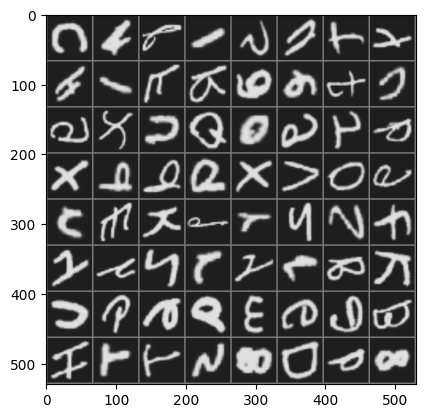

In [12]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake_images = netG(noise).detach()
generated_grid = torchvision.utils.make_grid(fake_images[:64], nrow=8, padding=2)
imshow(generated_grid)

In [10]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("")
N, C, H, W = 4, 3, 8, 8
x = torch.randn(N, C, H, W, device=device, dtype=torch.float32)
bn_native = nn.BatchNorm2d(C, eps=1e-5, affine=True).to(device)
bn_native.train()
bn_custom = CustomBatchNorm2d(C, eps=1e-5).to(device)
bn_custom.train()
bn_custom.gamma.data = bn_native.weight.data.clone()
bn_custom.beta.data = bn_native.bias.data.clone()
out_native = bn_native(x)
out_custom = bn_custom(x)

difference_norm = torch.norm(out_native - out_custom)

print("Testing of PyTorch vs Custom Implementation of BatchNorm2d")
print("Difference norm between native and custom BN outputs:", difference_norm.item())
print("Native output (sample):", out_native[0, 0, :2, :2])
print("Custom output (sample):", out_custom[0, 0, :2, :2])


Using device: cuda

Testing of PyTorch vs Custom Implementation of BatchNorm2d
Difference norm between native and custom BN outputs: 37.98070526123047
Native output (sample): tensor([[-0.6496,  1.9574],
        [-0.8521, -0.0281]], device='cuda:0', grad_fn=<SliceBackward0>)
Custom output (sample): tensor([[-1.2904,  1.1021],
        [ 0.2091,  0.4083]], device='cuda:0', grad_fn=<SliceBackward0>)


In [11]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("")

# params
batch = 2
nz = 100
out_channels = 512
kernel_size = 4

input_tensor = torch.randn(batch, nz, 1, 1, device=device, dtype=torch.float32)
weight_tensor = torch.randn(nz, out_channels, kernel_size, kernel_size, device=device, dtype=torch.float32)
custom_layer = CustomConvTranspose2d(nz, out_channels, kernel_size=kernel_size, stride=1, padding=0).to(device)
custom_layer.weight.data = weight_tensor.clone()
output_custom = custom_layer(input_tensor)
conv_transpose = nn.ConvTranspose2d(nz, out_channels, kernel_size, stride=1, padding=0, bias=False).to(device)
conv_transpose.weight.data = weight_tensor.clone()
output_native = conv_transpose(input_tensor)

difference_norm = torch.norm(output_custom - output_native)

print("Testing of PyTorch vs Custom Implementation of ConvTranspose2d")
print("Difference norm between custom and native outputs:", difference_norm.item())
print("Custom output shape:", output_custom.shape)
print("Native output shape:", output_native.shape)

Using device: cuda

Testing of PyTorch vs Custom Implementation of ConvTranspose2d
Difference norm between custom and native outputs: 1233.186279296875
Custom output shape: torch.Size([2, 512, 4, 4])
Native output shape: torch.Size([2, 512, 4, 4])
